In [1]:
import numpy as np, pandas as pd
# file_name = './data/iqiyi_processed_116_39.7_0.2_None'
file_name = '../data/iqiyi_processed'
file_name = "../data/ip_data_solve"

class_number = 20

In [2]:
read_file = file_name + '.csv'
print(read_file)
df = pd.read_csv(read_file, header=None, names = ['uid', 'timestamp', 'lat', 'lon', 'vid'])
df.head()

./data/iqiyi_processed.csv


,uid,timestamp,lat,lon,vid
0,570197,1430668800,116.421540,40.036060,109
1,294391,1430668800,116.144120,39.726334,906
2,281378,1430668800,116.321900,40.089973,12642
3,523921,1430668800,116.386986,39.991596,1568
4,35562,1430668800,116.387340,39.991910,143067


In [3]:
df_group = df.groupby(['uid'])['vid'].apply(lambda x : ' '.join([str(m) for m in x])).reset_index()
df_group.head()

,uid,vid
0,0,6347 1699 45 45 57 2 36 193 1017 45 1017 45 10...
1,1,6987 6067 93401 366 5364 41552 4743 5121 1886 ...
2,2,41398 574 974 220 36 14 29436 36 14 1030 14 14...
3,3,31423 349801 28169 114 36 28169 8382 28169 282...
4,4,2712 30515 1353 198 1353 198 19710 2200 14201 ...


In [4]:
group_file = file_name + '_group.csv'
print(group_file)
df_group.to_csv(group_file, index=False)

./data/iqiyi_processed_group.csv


In [5]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySpark Item2vec").getOrCreate()

sc = spark.sparkContext

In [6]:
print(group_file)
df = spark.read.csv(group_file, header=True)
df.show(5)

./data/iqiyi_processed_group.csv
+---+--------------------+
|uid|                 vid|
+---+--------------------+
|  0|6347 1699 45 45 5...|
|  1|6987 6067 93401 3...|
|  2|41398 574 974 220...|
|  3|31423 349801 2816...|
|  4|2712 30515 1353 1...|
+---+--------------------+
only showing top 5 rows



In [7]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

df = df.withColumn('vid', F.split(df.vid, ' '))

In [8]:
from pyspark.ml.feature import Word2Vec
word2Vec = Word2Vec(
  vectorSize=5,
  minCount=0,
  inputCol='vid',
  outputCol='vid2vec'
)

model=word2Vec.fit(df)

In [9]:
model.getVectors().show(3, truncate=False)

C:\Users\86199\software\spark-3.2.1-bin-hadoop3.2-scala2.13\python\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+------+--------------------------------------------------------------------------------------------------------+
|word  |vector                                                                                                  |
+------+--------------------------------------------------------------------------------------------------------+
|144322|[1.2897599935531616,0.269665390253067,-0.6925342679023743,0.2827008366584778,0.6024227142333984]        |
|354226|[0.23641060292720795,0.04806879162788391,-0.10142932832241058,-0.007465722970664501,0.08431300520896912]|
|258484|[0.11295992881059647,-0.047181010246276855,-0.170566126704216,0.040997207164764404,0.1939992755651474]  |
+------+--------------------------------------------------------------------------------------------------------+
only showing top 3 rows



In [10]:
item2vec_file = file_name + '_item2vec.csv'
print(item2vec_file)
model.getVectors().select("word", "vector").toPandas().to_csv(item2vec_file, index=False)

./data/iqiyi_processed_item2vec.csv


In [11]:
print(item2vec_file)
df = pd.read_csv(item2vec_file)
df.head()

./data/iqiyi_processed_item2vec.csv


,word,vector
0,144322,"[1.2897599935531616,0.269665390253067,-0.69253..."
1,354226,"[0.23641060292720795,0.04806879162788391,-0.10..."
2,258484,"[0.11295992881059647,-0.047181010246276855,-0...."
3,292675,"[0.15078236162662506,-0.03805669769644737,-0.2..."
4,390573,"[0.048638246953487396,-0.12122812122106552,-0...."


In [12]:
import json, numpy as np
df['vector'] = df['vector'].map(lambda x : np.array(json.loads(x)))
df.head()

,word,vector
0,144322,"[1.2897599935531616, 0.269665390253067, -0.692..."
1,354226,"[0.23641060292720795, 0.04806879162788391, -0...."
2,258484,"[0.11295992881059647, -0.047181010246276855, -..."
3,292675,"[0.15078236162662506, -0.03805669769644737, -0..."
4,390573,"[0.048638246953487396, -0.12122812122106552, -..."


In [13]:
from sklearn.cluster import KMeans

clt = KMeans(n_clusters = class_number)
data = []
for i in range(len(df)):
  vec = df.iloc[i]['vector']
  data.append(vec)

estimator = clt.fit(data)

In [14]:
import csv

label_pred = estimator.labels_
classified_file = file_name + "_" + str(class_number) + "_cf_classifier.csv"
print(classified_file)
f = open(classified_file, 'w', newline='')
csv_writer = csv.writer(f)
write_data = []
for i in range(len(label_pred)):
  write_data = [df.iloc[i]['word'], label_pred[i]]
  csv_writer.writerow(write_data)
f.close()


./data/iqiyi_processed_20_cf_classifier.csv


In [15]:
import matplotlib.pyplot as plt
class_dic = {}
print(classified_file)
reader = pd.read_csv(classified_file ,header=None, iterator=True, 
    chunksize=400, nrows=None)
for chunk in reader:
  for i in range(len(chunk)):
    data_now = chunk.iloc[i]
    vid_now = int(data_now[0])
    class_id = int(data_now[1])
    class_dic[vid_now] = class_id


./data/iqiyi_processed_20_cf_classifier.csv


./data/iqiyi_processed_116_39.7_0.2_None.csv
100000 data has already done
200000 data has already done
300000 data has already done
400000 data has already done
500000 data has already done
600000 data has already done
700000 data has already done
800000 data has already done
900000 data has already done
1000000 data has already done
1100000 data has already done
1200000 data has already done
1300000 data has already done


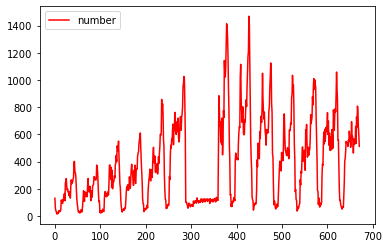

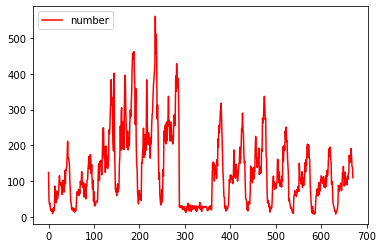

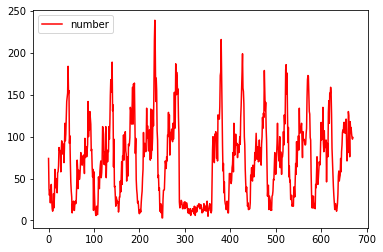

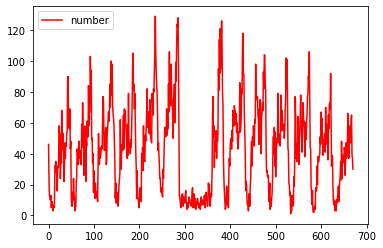

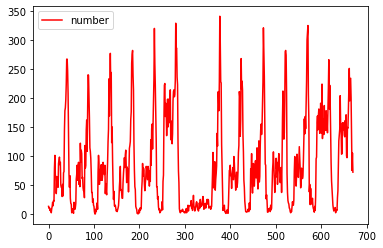

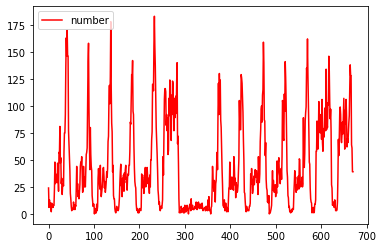

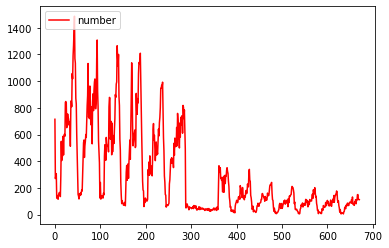

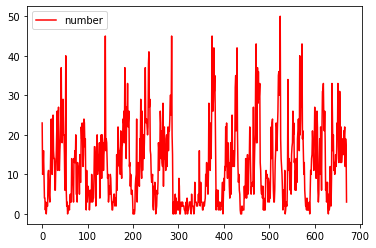

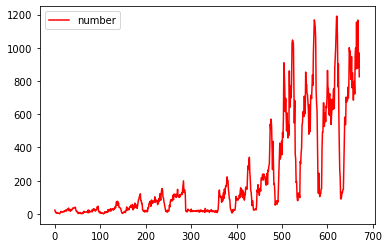

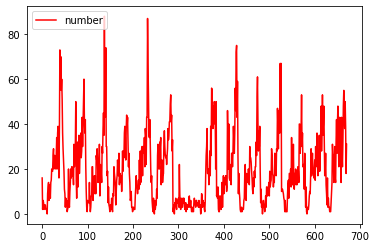

In [17]:
read_file = file_name + '.csv'
read_file = './data/iqiyi_processed_116_39.7_0.2_None' + '.csv'

time_gap = 1800
time_end = 1430668800 + time_gap
print(read_file)


reader = pd.read_csv(read_file ,header=None, iterator=True, 
    chunksize=400, nrows=None)

lists = [[] for i in range(class_number)]
cnt_count = np.zeros(class_number)

tot_data_len = 0
f = open('./data/input_20km_20class.csv', 'w', newline='')
csv_writer = csv.writer(f)

for chunk in reader:
  tot_data_len += len(chunk)
  if chunk.iloc[0][1] > time_end:
    write_data = []
    for j in range(class_number):
      write_data.append(int(cnt_count[j]))
      lists[j].append(cnt_count[j])
    csv_writer.writerow(write_data) 
    time_end += time_gap
    cnt_count.fill(0)
  for i in range(len(chunk)):
    data_now = chunk.iloc[i]
    vid_real = int(data_now[4])
    vid_class = class_dic[vid_real]
    cnt_count[vid_class] += 1
    
  if tot_data_len % 100000 == 0:
      print("%d data has already done" % (tot_data_len))
f.close()

for i in range(10):
  l1, = plt.plot(lists[i], color='red')
  plt.legend(handles=[l1], labels=['number'], loc='upper left')
  plt.show()